In [1]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")
import mplhep as hep
import pickle
import glob
import ROOT
import coffea
import awkward as ak
from coffea import hist, processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector


Welcome to JupyROOT 6.28/00


In [2]:
print(coffea.__version__)

0.7.13


In [3]:
#paths to data
EraE_Path = "/eos/uscms/store/user/amalbert/MDSTriggerEff/TnP_newCuts/MuonSystem_TnP_firstTests_Run2022EraE_newCuts.root"
EraF_Path = "/eos/uscms/store/user/amalbert/MDSTriggerEff/TnP_FirstOutput/Run2022EraF.root"
EraG_Path = "/eos/uscms/store/user/amalbert/MDSTriggerEff/TnP_FirstOutput/Run2022EraG.root"

In [4]:
ak.behavior.update(candidate.behavior)

def getLZDF(f,nEvents=-1,version="new"): #lazy dataframe with events that have cluster matched to probe muon
    events_raw = uproot.open(f)['MuonSystem']
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    events = events[start:stop]
    return events

In [5]:
events_E = getLZDF(EraE_Path)
events_F = getLZDF(EraF_Path)
events_G = getLZDF(EraG_Path)

In [6]:
events_E.fields

['runNum',
 'MC_condition',
 'lumiSec',
 'evtNum',
 'mH',
 'mX',
 'ctau',
 'category',
 'npv',
 'npu',
 'weight',
 'lepOverallSF',
 'pileupWeight',
 'Flag_HBHENoiseFilter',
 'Flag_BadPFMuonFilter',
 'Flag_HBHEIsoNoiseFilter',
 'Flag_CSCTightHaloFilter',
 'Flag_globalSuperTightHalo2016Filter',
 'Flag_goodVertices',
 'Flag_ecalBadCalibFilter',
 'Flag_BadChargedCandidateFilter',
 'Flag_eeBadScFilter',
 'Flag_all',
 'Flag2_HBHENoiseFilter',
 'Flag2_HBHEIsoNoiseFilter',
 'Flag2_BadPFMuonFilter',
 'Flag2_globalSuperTightHalo2016Filter',
 'Flag2_globalTightHalo2016Filter',
 'Flag2_BadChargedCandidateFilter',
 'Flag2_EcalDeadCellTriggerPrimitiveFilter',
 'Flag2_ecalBadCalibFilter',
 'Flag2_eeBadScFilter',
 'Flag2_all',
 'rho',
 'met',
 'metPhi',
 'gHiggsPt',
 'gHiggsE',
 'gHiggsEta',
 'gHiggsPhi',
 'nCscRings',
 'nDtRings',
 'nCscRechitClusters',
 'cscRechitCluster_match_gLLP',
 'cscRechitCluster_match_gLLP_minDeltaR',
 'cscRechitCluster_match_gLLP_index',
 'cscRechitCluster_match_gLLP_eta',
 

In [44]:
testArray = ak.Array([[1,None],[3,4],[5]])
maskArray = ak.Array([[True, False], [False, False], [True]])
ak.mask(testArray, maskArray)

<Array [[1, None], [None, None], [5]] type='3 * var * ?int64'>

In [111]:
events_E.nCscRechitClusters

<Array [1, 1, 1, 2, 1, 2, ... 1, 1, 1, 1, 2, 1] type='14902 * int32'>

In [70]:
events_E.cscRechitClusterX[2]

<Array [-81.7, 105] type='2 * float32'>

In [112]:
events_E_clusterMask = ak.mask(events_E.cscRechitClusterSize, events_E.cscRechitCluster_matchToProbeMuon)

In [118]:
ak.count_nonzero(ak.flatten(events_E_clusterMask))

15743

In [94]:
events_E.HLT_CscCluster_Loose

<Array [False, False, False, ... False, False] type='9784 * bool'>

In [127]:
ak.count_nonzero(ak.mask(events_E, events_E.HLT_CscCluster_Loose).cscRechitClusterSize)

342

In [84]:
ak.mask(events_E, events_E.HLT_CscCluster_Loose).cscRechitClusterSize

AttributeError: no field named 'cscRechitClusterSize'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.1/src/awkward/highlevel.py#L1124)

In [74]:
ak.mask(events_E, ak.flatten(events_E["cscRechitCluster_matchToProbeMuon"])).cscRechitClusterX[2]

ValueError: cannot repartition array of length 12926 to length 9784

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.1/src/libawkward/partition/IrregularlyPartitionedArray.cpp#L75)

In [52]:
ak.flatten(ak.flatten(events_E_masked.cscRechitClusterSize))

<Array [54, 108, 68, 65, ... 91, 192, 64, 70] type='12926 * int32'>

In [68]:
ak.mask(events_E, events_E["cscRechitCluster_matchToProbeMuon"]).

<Array [[{runNum: 359699, ... ] type='9784 * var * ?{"runNum": uint32, "MC_condi...'>

In [38]:
events_E_masked = ak.mask(events_E, events_E["cscRechitCluster_matchToProbeMuon"])
events_E_masked["HLT_CscCluster_Loose"][11]

<Array [False] type='1 * ?bool'>

In [45]:
#mask events that do not have a muon matched with the cluster (ie. muonPt is 0 because it has not been filled)
events_E_masked = ak.mask(events_E, events_E["cscRechitCluster_matchToProbeMuon"])
events_F_masked = ak.mask(events_F, events_F["cscRechitClusterMuonVetoPt"]>0)
events_G_masked = ak.mask(events_G, events_G["cscRechitClusterMuonVetoPt"]>0)

#apply additional mask based on HLT Decisions
eraE_HLTDecisions = {}
eraE_HLTDecisions["HLT_CscCluster_Loose"] = ak.mask(events_E_masked, events_E_masked["HLT_CscCluster_Loose"])
eraE_HLTDecisions["HLT_CscCluster_Medium"] = ak.mask(events_E_masked, events_E_masked["HLT_CscCluster_Medium"])
eraE_HLTDecisions["HLT_CscCluster_Tight"] = ak.mask(events_E_masked, events_E_masked["HLT_CscCluster_Tight"])

eraF_HLTDecisions = {}
eraF_HLTDecisions["HLT_CscCluster_Loose"] = ak.mask(events_F_masked, events_F_masked["HLT_CscCluster_Loose"]>0)
eraF_HLTDecisions["HLT_CscCluster_Medium"] = ak.mask(events_F_masked, events_F_masked["HLT_CscCluster_Medium"]>0)
eraF_HLTDecisions["HLT_CscCluster_Tight"] = ak.mask(events_F_masked, events_F_masked["HLT_CscCluster_Tight"]>0)

eraG_HLTDecisions = {}
eraG_HLTDecisions["HLT_CscCluster_Loose"] = ak.mask(events_G_masked, events_G_masked["HLT_CscCluster_Loose"]>0)
eraG_HLTDecisions["HLT_CscCluster_Medium"] = ak.mask(events_G_masked, events_G_masked["HLT_CscCluster_Medium"]>0)
eraG_HLTDecisions["HLT_CscCluster_Tight"] = ak.mask(events_G_masked, events_G_masked["HLT_CscCluster_Tight"]>0)


In [46]:
ak.flatten(events_E_masked.ZMass)

<Array [80.6, 99.6, 89.6, ... 90.5, 86.3, 88.8] type='12926 * ?float32'>

In [47]:
ak.flatten(ak.flatten(events_E_masked.cscRechitClusterSize))

<Array [54, 108, 68, 65, ... 91, 192, 64, 70] type='12926 * int32'>

(0.0, 200.0)

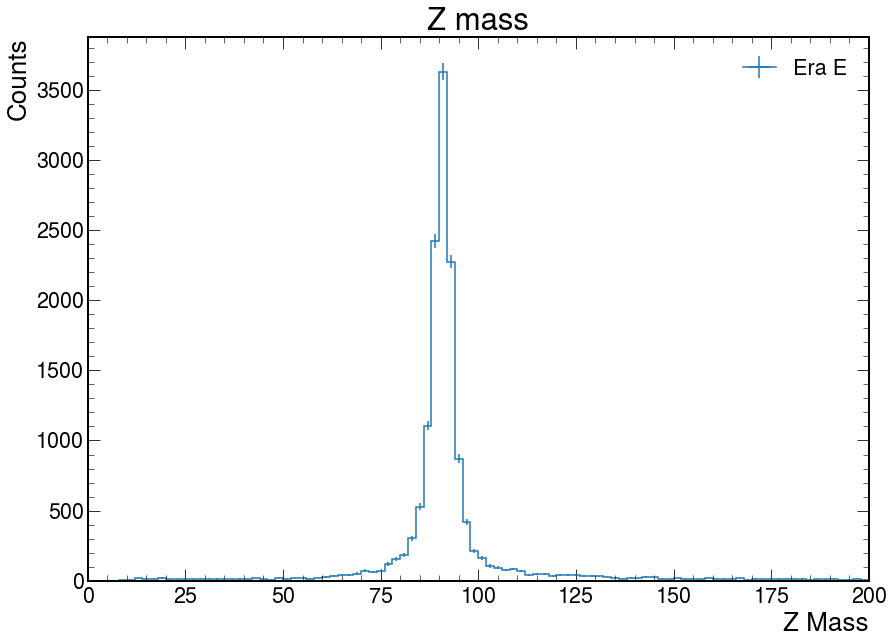

In [9]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))
rechits_axis = hist.Cat("sample", "2022 Era")
ZMass_hist = hist.Hist("Counts", rechits_axis, hist.Bin("ZMass", "Z Mass", 100, 0, 200))
ZMass_hist.fill(sample = 'Era E', ZMass = events_E.ZMass)
hist.plot1d(ZMass_hist, density=False)
plt.legend()
plt.title("Z mass")
plt.xlim(0,200)

In [49]:
bins = hist.Bin("cluster_size", "Cluster Size", 50, 0, 1000)

In [60]:
ak.flatten(events_E_masked.cscRechitClusterSize)[2]

<Array [68, 65] type='2 * int32'>

(0.0, 800.0)

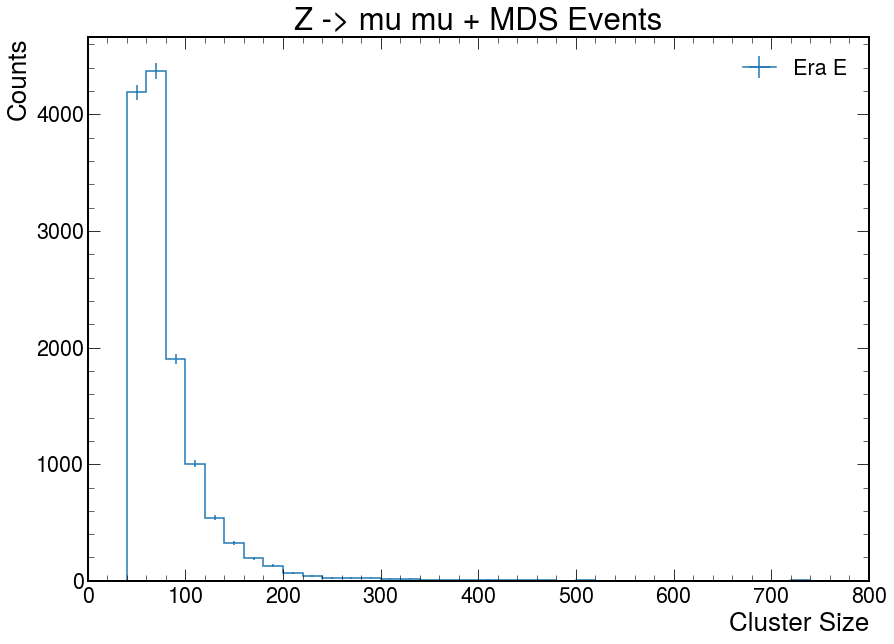

In [53]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))
rechits_axis = hist.Cat("sample", "2022 Era")
rechits_hist = hist.Hist("Counts", rechits_axis, bins)
rechits_hist.fill(sample = 'Era E', cluster_size=ak.flatten(ak.flatten(events_E_masked.cscRechitClusterSize)))
hist.plot1d(rechits_hist, density=False)
plt.legend()
plt.title("Z -> mu mu + MDS Events")
plt.xlim(0,800)

<AxesSubplot:title={'center':'Z -> mu mu + MDS + Fire HLT Loose Events'}, xlabel='Cluster Size', ylabel='Counts'>

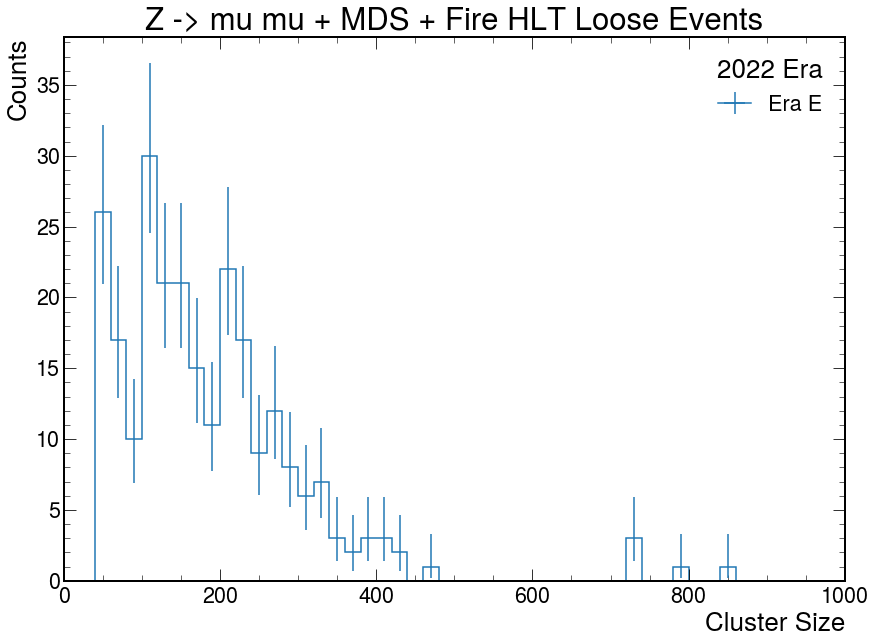

In [54]:
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))
rechits_hist_HLTLoose = hist.Hist("Counts", rechits_axis, bins)
rechits_hist_HLTLoose.fill(sample = "Era E",cluster_size=ak.flatten(ak.flatten(eraE_HLTDecisions["HLT_CscCluster_Loose"].cscRechitClusterSize)))
plt.title("Z -> mu mu + MDS + Fire HLT Loose Events")
hist.plot1d(rechits_hist_HLTLoose, density=False)
#plt.xlim(0,300)
#rechits_hist.plot1d_ratio()

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


Text(0, 1, 'Efficiency')

<Figure size 2160x720 with 0 Axes>

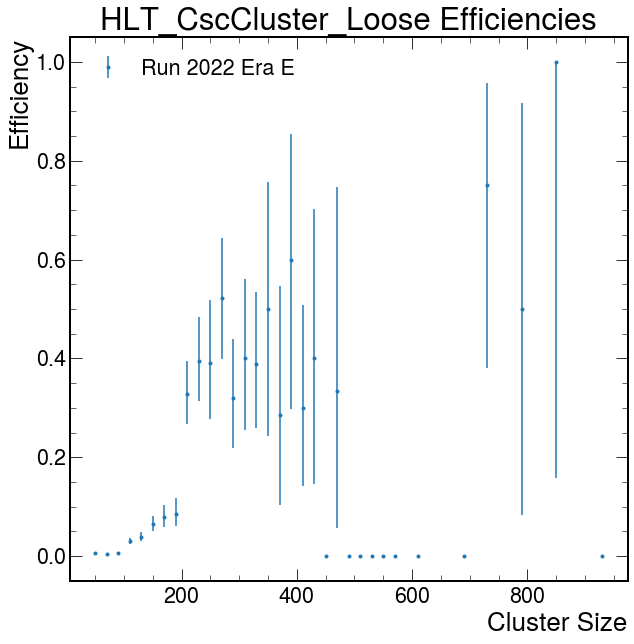

In [55]:
plt.figure(figsize=(30,10))
hist.plotratio(
            #ax=rechits_axis,
            num  =rechits_hist_HLTLoose.project(bins),
            denom=rechits_hist.project(bins),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label="Run 2022 Era E",
            clear=False
        )
plt.legend()
plt.title("HLT_CscCluster_Loose Efficiencies")
plt.ylabel("Efficiency")
#plt.xlim(0,300)

In [ ]:
ratio_hist.project()

In [103]:

#rechits_hist = rechits_hist.to_hist().Clone()
#rechits_hist_HLTLoose_root = rechits_hist_HLTLoose.to_hist()
#print(type(rechits_hist_root))
efficiency_hist_root = rechits_hist_HLTLoose.divide(rechits_hist)


AttributeError: 'Hist' object has no attribute 'divide'

In [83]:
print(rechits_hist_HLTLoose.values()[('Run 2022 Era E',)])
print(rechits_hist.values()[('Run 2022 Era E',)])
divided = np.divide(rechits_hist_HLTLoose.values()[('Run 2022 Era E',)], rechits_hist.values()[('Run 2022 Era E',)], where=(rechits_hist.values()[('Run 2022 Era E',)]!=0))
divided

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 2. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 1. 1.
 0. 1. 1. 0. 0. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 2. 6. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 208. 177. 124.  98.
  77.  86.  61.  48.  44.  43.  36.  25.  26.  21.  24.  11.  13.  15.
   5.  10.  11.   4.   6.   3.   2.   4.   2.   4.   1.   2.   4.   1.
   0.   2.   5.   8.   0.   0.   1.   1.   4.   0.   0.   0.   3.   0.
   0.   4.   0.   0.   2.   1.   1.   1.   0.   2.   0.   1.   0.   0.
   2.   1.   1.   0.   0.   1.   0.

array([1.63905867e-315, 1.54177540e-315, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 2.88461538e-002, 1.12994350e-002,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       5.55555556e-002, 4.00000000e-002, 3.84615385e-002, 4.76190476e-002,
       0.00000000e+000, 9.09090909e-002, 7.69230769e-002, 0.00000000e+000,
       0.00000000e+000, 2.00000000e-001, 9.09090909e-002, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       2.50000000e-001, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       4.00000000e-001, 7.50000000e-001, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 1.00000000e+000, 2.50000000e-001, 0.00000000e+000,
       0.00000000e+000, 0

/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:53: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/plot.py:53: RuntimeWarning: invalid value encountered in true_divide
  counts = sumw / scale


Text(0.5, 1.0, 'HLT_CscCluster_Loose Trigger Rate')

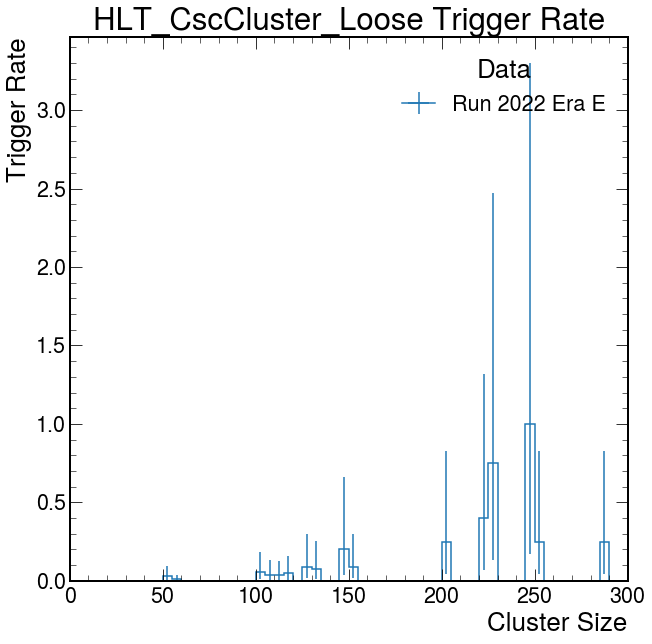

In [94]:
#print(np.divide(rechits_hist_HLTLoose.values()[('Run 2022 Era E',)], rechits_hist.values()[('Run 2022 Era E',)], where=(rechits_hist.values()[('Run 2022 Era E',)]!=0)))
#efficiency_hist = hist.Hist("Counts", rechits_axis)
#efficiency_hist.values()[:] = np.divide(rechits_hist_HLTLoose.values().values(), rechits_hist.values.values(), where=(rechits_hist.values.values().values()!=0))
bins = hist.Bin("cluster_size", "Cluster Size", 200, 0, 1000)
efficiency_hist = hist.Hist("Trigger Rate", rechits_axis, bins)
efficiency_hist.fill(nRechits = "Run 2022 Era E", cluster_size = bins.centers() , weight=divided)
hist.plot1d(efficiency_hist)
plt.xlim(0,300)
plt.title("HLT_CscCluster_Loose Trigger Rate")

In [113]:
denom = ROOT.TH1F("denom", "nRechits", 200, 0, 1000)
for x in range(len(ak.flatten(ak.flatten(events_E_masked.cscRechitClusterSize)))):
    denom.Fill(ak.flatten(ak.flatten(events_E_masked.cscRechitClusterSize))[x])
    
numer = ROOT.TH1F("numer", "nRechits_passHLTLoose", 200, 0, 1000)
for x in range(len(ak.flatten(ak.flatten(eraE_HLTDecisions["HLT_CscCluster_Loose"].cscRechitClusterSize)))):
    numer.Fill(ak.flatten(ak.flatten(eraE_HLTDecisions["HLT_CscCluster_Loose"].cscRechitClusterSize))[x])
    

Warning in <TROOT::Append>: Replacing existing TH1: denom (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numer (Potential memory leak).


In [116]:
eff = numer.Clone()
eff.Divide(denom)

True

<Figure size 1008x720 with 0 Axes>

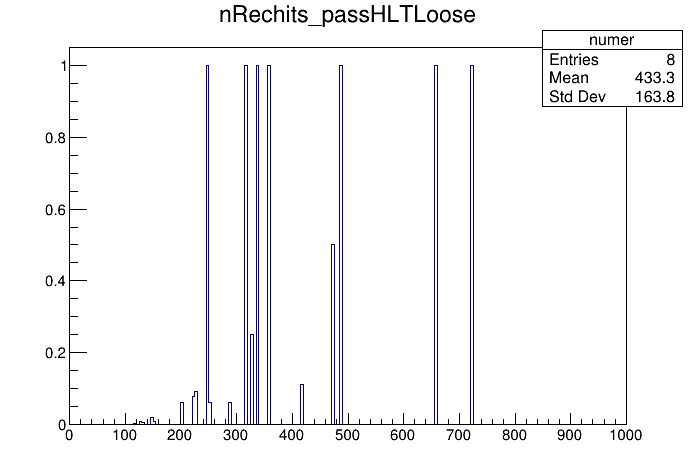

In [122]:
C = ROOT.TCanvas()
plt.style.use(hep.style.CMS) 
plt.figure(figsize=(14,10))
eff.Draw()
C.Draw()

In [ ]:
hist.plotratio()